In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
import os
import json
from scipy.special import expit
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    roc_auc_score,
    balanced_accuracy_score,
    classification_report,
)

# We assume attention_pooling_model.py is in the same directory
from attention_pooling_model import AttentionCBM

# PyTorch Dataset for raw embeddings
class CEMRawDataset(Dataset):
    def __init__(self, X_raw, C, y):
        self.X_raw = X_raw
        self.C = torch.tensor(C, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_raw[idx], self.y[idx], self.C[idx]

# Custom collate_fn for handling variable-length raw embeddings
def custom_collate_fn(batch):
    # FIX 1: Convert nested object arrays to proper float tensors
    x_raw_batch = []
    for item in batch:
        # Handle nested object array: convert to proper numpy array first
        x_np = np.array(item[0], dtype=np.float32)
        x_tensor = torch.from_numpy(x_np)
        x_raw_batch.append(x_tensor)
    
    # Pad sequences to the max length in the batch for the forward pass
    x_padded = nn.utils.rnn.pad_sequence(x_raw_batch, batch_first=True, padding_value=0.0)
    y_batch = torch.stack([item[1] for item in batch])
    c_batch = torch.stack([item[2] for item in batch])
    return x_padded, y_batch, c_batch


def train_attention_cem():
    print("Starting: Train Attention CBM")

    # Load data
    project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
    data_path = os.path.join(project_root, "data/processed/cem_input_raw.npz")
    logs_dir = os.path.join(project_root, "logs")
    
    if not os.path.exists(data_path):
        print(f"Error: Input file not found at {data_path}")
        print("Please run 3_prepare_attention_data.ipynb first.")
        return
        
    data = np.load(data_path, allow_pickle=True)
    X_raw = data["X_raw"]
    C = data["C"]
    y = data["y"]
    concept_names = data["concept_names"]

    # Train/Val/Test split
    train_idx, test_idx = train_test_split(np.arange(len(y)), test_size=0.2, stratify=y, random_state=42)
    train_idx, val_idx = train_test_split(train_idx, test_size=0.2, stratify=y[train_idx], random_state=42)

    print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")

    # Create datasets
    train_ds = CEMRawDataset(X_raw[train_idx], C[train_idx], y[train_idx])
    val_ds = CEMRawDataset(X_raw[val_idx], C[val_idx], y[val_idx])
    test_ds = CEMRawDataset(X_raw[test_idx], C[test_idx], y[test_idx])

    # Create DataLoaders
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
    val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, collate_fn=custom_collate_fn)
    test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, collate_fn=custom_collate_fn)

    # Parameters
    embed_dim = X_raw[0].shape[1]
    n_concepts = C.shape[1]
    n_tasks = 1

    def c_extractor_arch(output_dim: int):
        return nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, output_dim)
        )

    # Instantiate model
    cem_model = AttentionCBM(
        n_concepts=n_concepts,
        n_tasks=n_tasks,
        embedding_dim=embed_dim,
        c_extractor_arch=c_extractor_arch,
        learning_rate=0.001,
    )

    # FIX 2: Configure trainer to use MacBook GPU (MPS)
    pl.seed_everything(42)
    logger = CSVLogger(save_dir=logs_dir, name="attention_cem_experiment")
    
    # Detect available device and configure trainer
    if torch.backends.mps.is_available():
        accelerator = "mps"
        devices = 1
        print("Using MacBook GPU (MPS)")
    elif torch.cuda.is_available():
        accelerator = "gpu"
        devices = 1
        print("Using CUDA GPU")
    else:
        accelerator = "cpu"
        devices = 1
        print("Using CPU")
    
    trainer = pl.Trainer(
        max_epochs=100,
        logger=logger,
        log_every_n_steps=10,
        accelerator=accelerator,
        devices=devices,
    )

    # Train model
    print("Training model...")
    trainer.fit(cem_model, train_loader, val_loader)
    print("Training complete.")

    # Evaluation
    print("Evaluating model...")
    cem_model.eval()
    y_true_list, y_pred_list, y_prob_list = [], [], []

    # FIX 4: Use appropriate device for evaluation
    device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device for evaluation: {device}")
    cem_model.to(device)

    with torch.no_grad():
        for xb, yb, cb in test_loader:
            xb = xb.to(device)
            
            # CRITICAL FIX: Apply attention pooling before forward pass
            pooled_embeddings = cem_model.attention_pooler(xb)
            _, y_logits = cem_model(pooled_embeddings)
            
            y_logits = y_logits.detach().cpu().squeeze()
            
            if y_logits.ndim == 2 and y_logits.shape[1] == 1:
                y_logits = y_logits[:, 0]

            # FIX 3: Add .ravel() to ensure 1D arrays for sklearn
            yb_numpy = yb.numpy().astype(int).ravel()
            y_probs = expit(y_logits.numpy()).ravel()
            y_pred = (y_probs >= 0.5).astype(int)

            y_true_list.extend(yb_numpy.tolist())
            y_pred_list.extend(y_pred.tolist())
            y_prob_list.extend(y_probs.tolist())

    y_true = np.array(y_true_list)
    y_pred = np.array(y_pred_list)
    y_prob = np.array(y_prob_list)
    
    # Metrics
    acc = accuracy_score(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob)
    mcc = matthews_corrcoef(y_true, y_pred)
    f1_binary = f1_score(y_true, y_pred, pos_label=1)
    
    print("\nEvaluation summary")
    print("==================")
    print(f"Accuracy: {acc:.4f}")
    print(f"Balanced accuracy: {balanced_acc:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Matthews correlation coefficient: {mcc:.4f}")
    print(f"F1 score (binary): {f1_binary:.4f}")
    print("\nClassification report:")
    print(classification_report(y_true, y_pred))

    # Save metrics
    metrics_dict = {
        "accuracy": acc,
        "balanced_accuracy": balanced_acc,
        "roc_auc": roc_auc,
        "mcc": mcc,
        "f1_binary": f1_binary,
    }
    metrics_path = os.path.join(logs_dir, "eval_metrics_attention_cem.json")
    with open(metrics_path, "w") as f:
        json.dump(metrics_dict, f, indent=4)
    print(f"\nSaved metrics to {metrics_path}")


if __name__ == '__main__':
    train_attention_cem()

Global seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/miniconda3/envs/38concept_embedding/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:101: UserWarning: attribute 'c_extractor_arch' removed from hparams because it cannot be pickled
  rank_zero_warn(f"attribute '{k}' removed from hparams because it cannot be pickled")
/opt/miniconda3/envs/38concept_embedding/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name             | Type              | Params
-------------------------------------------------------
0 | attention_pooler | AttentionPooler   | 49.4 K
1 | x_to_c_model     | Sequential        | 103 K 
2 | c_to_y_model     | Linear            | 22    
3 | loss_concept     | BCEWithLogitsLoss | 0     
4 | lo

Starting: Train Attention CBM
Train: 310, Val: 78, Test: 98
Using MacBook GPU (MPS)
Training model...


Sanity Checking: 0it [00:00, ?it/s]

/opt/miniconda3/envs/38concept_embedding/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/miniconda3/envs/38concept_embedding/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/opt/miniconda3/envs/38concept_embedding/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argume

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Training complete.
Evaluating model...
Using device for evaluation: mps

Evaluation summary
Accuracy: 0.8980
Balanced accuracy: 0.7756
ROC AUC: 0.8177
Matthews correlation coefficient: 0.6153
F1 score (binary): 0.6667

Classification report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        81
           1       0.77      0.59      0.67        17

    accuracy                           0.90        98
   macro avg       0.84      0.78      0.80        98
weighted avg       0.89      0.90      0.89        98


Saved metrics to /Users/gualtieromarencoturi/Desktop/thesis/Master-Thesis-CEM-Depression-etc-case-study/logs/eval_metrics_attention_cem.json


Loading model from: /Users/gualtieromarencoturi/Desktop/thesis/Master-Thesis-CEM-Depression-etc-case-study/logs/attention_cem_experiment/version_9/checkpoints/epoch=99-step=1000.ckpt


/opt/miniconda3/envs/38concept_embedding/lib/python3.8/site-packages/lightning_fabric/utilities/cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.lo

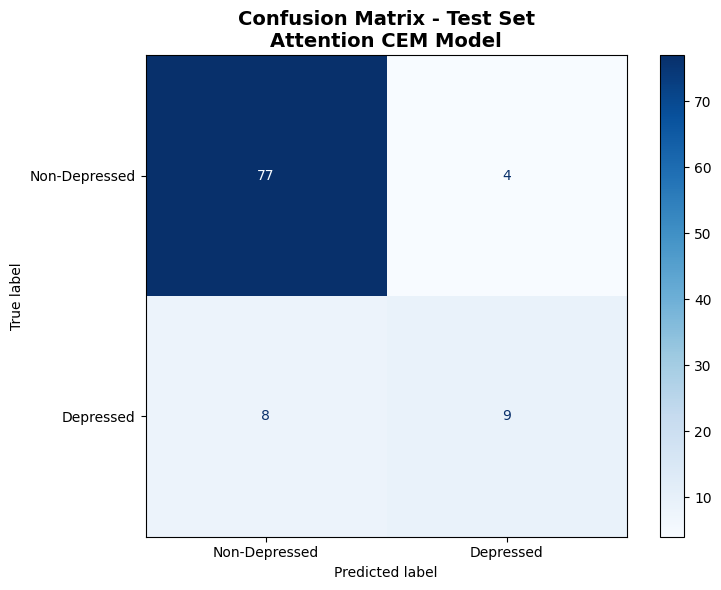


Confusion Matrix Breakdown:
True Negatives (TN): 77
False Positives (FP): 4
False Negatives (FN): 8
True Positives (TP): 9

Sensitivity (Recall): 0.5294
Specificity: 0.9506
Precision: 0.6923


In [6]:
# Confusion Matrix Visualization for Test Set
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from scipy.special import expit
import torch.nn as nn

# Load data
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
data_path = os.path.join(project_root, "data/processed/cem_input_raw.npz")

data = np.load(data_path, allow_pickle=True)
X_raw = data["X_raw"]
C = data["C"]
y = data["y"]

# Same split as training
train_idx, test_idx = train_test_split(np.arange(len(y)), test_size=0.2, stratify=y, random_state=42)

# Create test dataset and loader
test_ds = CEMRawDataset(X_raw[test_idx], C[test_idx], y[test_idx])
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, collate_fn=custom_collate_fn)

# Define c_extractor_arch (same as in training)
embed_dim = X_raw[0].shape[1]

def c_extractor_arch(output_dim: int):
    return nn.Sequential(
        nn.Linear(embed_dim, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, output_dim)
    )

# Load the trained model from checkpoint
checkpoint_dir = os.path.join(project_root, "logs/attention_cem_experiment")
# Find the latest version
import glob
version_dirs = glob.glob(os.path.join(checkpoint_dir, "version_*"))
if version_dirs:
    latest_version = sorted(version_dirs)[-1]
    checkpoint_files = glob.glob(os.path.join(latest_version, "checkpoints/*.ckpt"))
    if checkpoint_files:
        checkpoint_path = checkpoint_files[-1]
        print(f"Loading model from: {checkpoint_path}")
        
        # Load model with c_extractor_arch
        cem_model = AttentionCBM.load_from_checkpoint(
            checkpoint_path,
            c_extractor_arch=c_extractor_arch
        )
        cem_model.eval()
        
        # Get predictions
        device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
        cem_model.to(device)
        
        y_true_list, y_pred_list = [], []
        
        with torch.no_grad():
            for xb, yb, cb in test_loader:
                xb = xb.to(device)
                
                # Apply attention pooling before forward pass
                pooled_embeddings = cem_model.attention_pooler(xb)
                _, y_logits = cem_model(pooled_embeddings)
                
                y_logits = y_logits.detach().cpu().squeeze()
                
                if y_logits.ndim == 2 and y_logits.shape[1] == 1:
                    y_logits = y_logits[:, 0]
                
                yb_numpy = yb.numpy().astype(int).ravel()
                y_probs = expit(y_logits.numpy()).ravel()
                y_pred = (y_probs >= 0.5).astype(int)
                
                y_true_list.extend(yb_numpy.tolist())
                y_pred_list.extend(y_pred.tolist())
        
        y_true = np.array(y_true_list)
        y_pred = np.array(y_pred_list)
        
        # Create confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        
        # Plot confusion matrix
        fig, ax = plt.subplots(figsize=(8, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Depressed', 'Depressed'])
        disp.plot(cmap='Blues', ax=ax, values_format='d')
        
        plt.title('Confusion Matrix - Test Set\nAttention CEM Model', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Print additional stats
        tn, fp, fn, tp = cm.ravel()
        print(f"\nConfusion Matrix Breakdown:")
        print(f"True Negatives (TN): {tn}")
        print(f"False Positives (FP): {fp}")
        print(f"False Negatives (FN): {fn}")
        print(f"True Positives (TP): {tp}")
        print(f"\nSensitivity (Recall): {tp/(tp+fn):.4f}")
        print(f"Specificity: {tn/(tn+fp):.4f}")
        print(f"Precision: {tp/(tp+fp):.4f}")
    else:
        print("No checkpoint found!")
else:
    print("No training version found!")